<a href="https://colab.research.google.com/github/shreyus3003/Deep_Learning/blob/master/Home_work_4_Graded/resnet_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim


In [0]:

train = torchvision.datasets.CIFAR100(root = "./data", train=True, download = True, transform = transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(train, batch_size=4, shuffle = True)


Extracting ./data/cifar-100-python.tar.gz to ./data


In [0]:

class Block(nn.Module):


    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * Block.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * Block.expansion)
        )


        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != Block.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * Block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * Block.expansion)
            )
        
    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))
        
class Resent18(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
  
        self.conv2 = self._make_layer(block, 64, num_block[0], 1)
        self.conv3 = self._make_layer(block, 128, num_block[1], 2)
        self.conv4 = self._make_layer(block, 256, num_block[2], 2)
        self.conv5 = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers
          one layer may contain more than one residual block 

        Args:
            block: block type, basic block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        
        Return:
            return a resnet layer
        """

        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        
        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.conv4(output)
        output = self.conv5(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output 



def resnet18():
    """ return a ResNet 18 object
    """
    return Resent18(Block, [2, 2, 2, 2])

In [0]:
net = resnet18()


In [0]:


dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape) 


print(images[1].shape) 

print(labels[1].item())

torch.Size([4, 3, 32, 32])
torch.Size([3, 32, 32])
64


<class 'torch.Tensor'>
(3, 32, 32)
(32, 32, 3)


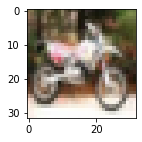

In [0]:


img = images[0]
print(type(img))


npimg = img.numpy()
print(npimg.shape)

npimg = np.transpose(npimg, (1, 2, 0))
print(npimg.shape)

plt.figure(figsize = (2,2))
plt.imshow(np.squeeze(npimg))
plt.show()

In [0]:

batch_size = 128

train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:

net = resnet18().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

In [0]:

def evaluate(dataloader):
    total, correct = 0, 0
    

    net.eval()
    for data in dataloader:
        inputs, labels = data

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [0]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 10

for epoch in range(max_epochs):

    for i, data in enumerate(train_loader, 0):
   
        net.train()
    
        inputs, labels = data
     
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()
     
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
     
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluate(train_loader), evaluate(test_loader)))
    
    
plt.plot(loss_epoch_arr)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()